<a href="https://colab.research.google.com/github/banished-panda/makemore/blob/main/Makemore(C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-07-10 07:06:48--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.009s  

2023-07-10 07:06:48 (23.3 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [3]:
words = open('names.txt').read().splitlines()
print(words[:5])
print('total words:', len(words))
vocab = sorted(list(set('.' + ''.join(words))))
print('vocab size:', len(vocab))
stoi = {s:i for i,s in enumerate(vocab)}
itos = {i:s for i,s in enumerate(vocab)}

['emma', 'olivia', 'ava', 'isabella', 'sophia']
total words: 32033
vocab size: 27


In [4]:
# split the dataset
train, dev, test = 0.8, 0.1, 0.1
assert train+dev+test == 1.0

ix_train = int(train * len(words))
ix_dev = int((train+dev) * len(words))

words_trn = words[:ix_train]
words_dev = words[ix_train:ix_dev]
words_tst = words[ix_dev:]

print(len(words_trn), len(words_dev), len(words_tst))

25626 3203 3204


In [5]:
def get_features_and_target(dataset, context_length=3):
  X, Y = [], []
  for word in dataset:
    context = [0] * context_length
    for ch in word+'.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = tf.constant(X)
  Y = tf.constant(Y)
  return X, Y

In [6]:
context_length = 4
X_tr, Y_tr = get_features_and_target(words_trn, context_length)

In [7]:
X_tr.shape

TensorShape([182778, 4])

In [8]:
X_tr[:5], Y_tr[:5]

(<tf.Tensor: shape=(5, 4), dtype=int32, numpy=
 array([[ 0,  0,  0,  0],
        [ 0,  0,  0,  5],
        [ 0,  0,  5, 13],
        [ 0,  5, 13, 13],
        [ 5, 13, 13,  1]], dtype=int32)>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([ 5, 13, 13,  1,  0], dtype=int32)>)

In [100]:
#fig, axs = plt.subplots(4) # (h_pre_act, h) (logits) (grad W1, grad W2)
def graph_distribution(params: list, param_names: list = None):
  plt.close()
  plt.figure(figsize=(9,4))
  legend = []
  if param_names:
    assert len(params) == len(param_names)
  for i, param in enumerate(params):
  #   if type(grad) == tf.IndexedSlices:
  # plt.hist(grad.values.numpy().reshape(-1), bins=50);
    if type(param) == tf.IndexedSlices:
      param = param.values
    y, x = np.histogram(param.numpy().reshape(-1), bins=50)
    y = y / y.max()
    std = ( y - y.mean()).std()
    legend.append(param_names[i] + f'(std:{std:.3})')
    plt.plot(x[1:], y)
  plt.legend(legend)

In [110]:
# ------------- MODEL -----------------

# - hyperparams -
embed_size = 10
random_seed = 2147483647
n_hidden = 300                        # No. of neuraons in hidden layer

# - model params -
g = tf.random.Generator.from_seed(random_seed)

# Embeding layer
C = tf.Variable(g.normal((27, embed_size)))

# Dense 1
W1 = tf.Variable(g.normal((embed_size*context_length, n_hidden)) / (embed_size*context_length)**0.5)
b1 = tf.Variable(g.normal((1, n_hidden)) * 0.00001)

# Dense 2
W2 = tf.Variable(g.normal((n_hidden,len(vocab))) / n_hidden**0.5)
b2 = tf.Variable(g.normal((1, len(vocab))) * 0.00001)

# trainable parameters
parameters = [C, W1, b1, W2, b2]

print('No. of params:', sum(tf.size(param).numpy() for param in parameters))

No. of params: 20697


In [118]:
# - optimiztaion -

epochs = 1
learning_rate = 1e-1
batch_size = 128

scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
tf.random.set_seed(random_seed)
losses = []
learning_rate = tf.constant(learning_rate, dtype=tf.float32)

for epoch in range(epochs):

  ixs = tf.random.shuffle(tf.range(X_tr.shape[0]))
  iters = int(X_tr.shape[0] / batch_size)
  average_loss = 0  # over one epoch
  prv_progress = -1
  print('Epoch:', epoch+1, 'learning_rate:', learning_rate.numpy())

  for i in range(iters):

    # optimize in mini-batches

    Xs = tf.gather(X_tr, ixs[ i*batch_size : (i+1)*batch_size])
    Ys = tf.gather(Y_tr, ixs[ i*batch_size : (i+1)*batch_size])

    # - forward pass -
    with tf.GradientTape() as tape:
      emb = tf.gather(C, Xs)
      h_pre_act = tf.reshape(emb, (batch_size, -1)) @ W1 + b1
      h = tf.math.tanh(h_pre_act)
      logits = h @ W2 + b2
      # loss
      loss = scce(Ys, logits)
    average_loss += loss.numpy()
    losses.append(loss.numpy())

    # - backward pass -
    gradients = tape.gradient(loss, parameters)

    # - update -
    for param, grad in zip(parameters, gradients):
      if type(grad) == tf.IndexedSlices:
        delta = tf.IndexedSlices(
            values = learning_rate * grad.values,
            indices = grad.indices,
            dense_shape = grad.dense_shape
        )
        param.assign_sub(delta)
      else:
        param.assign_sub(learning_rate * grad)

    # - display progress -
    progress = ((i+1) * 50) // iters
    if progress > prv_progress:
      print('\r',f'{i+1}/{iters} :\t','[', '='*(progress-1), '>', '-'*(50-progress),']\t','loss=',average_loss/(i+1), sep='', end='')
    prv_progress = progress

    # break

  average_loss /= iters
  print()
  learning_rate = learning_rate * 0.1 if (epoch+1)%3 == 0 else learning_rate

Epoch: 1 learning_rate: 0.1
1427/1427 :	[=================================================>]	loss=2.2297740049435695


In [13]:
# evaluate on a dataset
def evaluate(dataset):
  X_eval, Y_eval = get_features_and_target(dataset, context_length)
  emb = tf.gather(C, X_eval)
  h_pre_act = tf.reshape(emb, (X_eval.shape[0], -1)) @ W1 + b1
  h = tf.math.tanh(h_pre_act)
  logits = h @ W2 + b2
  scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  loss = scce(Y_eval, logits)
  return loss.numpy()

In [120]:
evaluate(words_trn), evaluate(words_dev)

(2.1861138, 2.4149468)

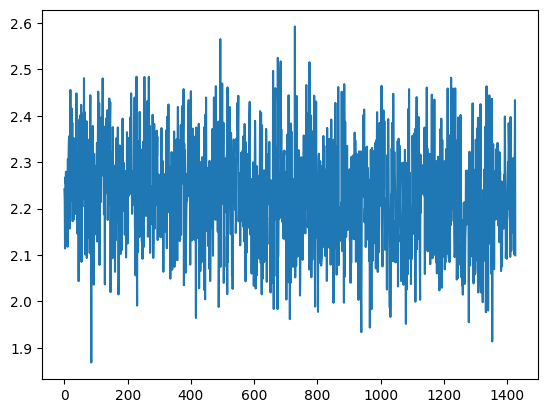

In [119]:
plt.plot(losses)

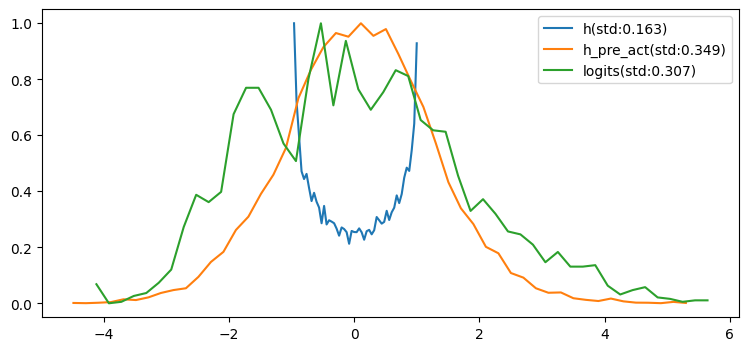

In [116]:
graph_distribution([h, h_pre_act, logits], param_names = ['h', 'h_pre_act', 'logits'])

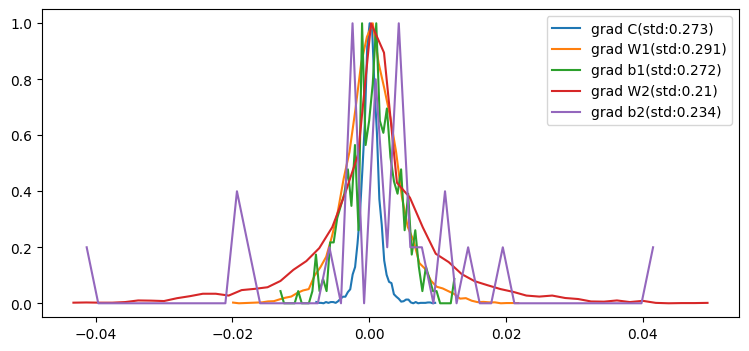

In [117]:
graph_distribution(gradients, ['grad C', 'grad W1', 'grad b1', 'grad W2', 'grad b2'])

In [15]:
# sampling
tf.random.set_seed(random_seed)
for _ in range(20):
  context = [0] * context_length
  out = []
  while True:
    _X = tf.constant([context])
    emb = tf.gather(C, _X)
    _h = tf.math.tanh( tf.reshape(emb,(_X.shape[0], -1)) @ W1 + b1)
    logits = _h @ W2 + b2
    ix = tf.random.categorical(logits, 1)[0][0].numpy()
    if ix == 0:
      break
    context = context[1:] + [ix]
    out.append(itos[ix])
  print(''.join(out))

arii
atdsonnaedln
srod
kyilyah
kerta
ihvie
siana
ralalenicyka
kunt
lakne
krhah
darrelle
mayne
ialrin
daret
tailya
carien
yrha
kanvina
zaylyna
